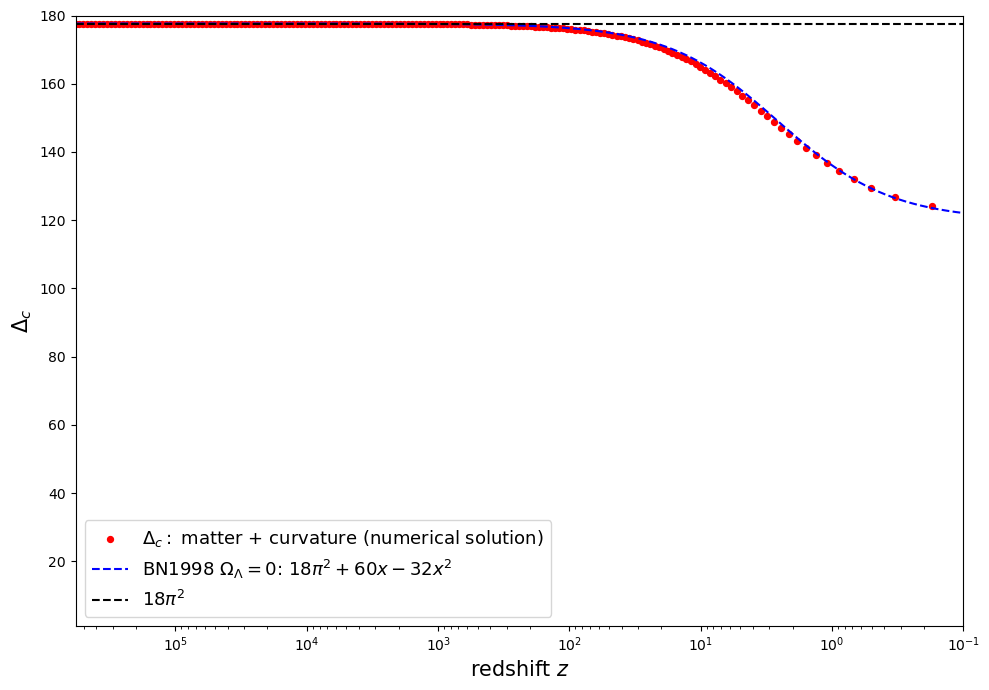

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


G = 1.0
Omega_m0 = 0.3
Omega_k0 = 1.0 - Omega_m0
# Omega_k0 = .5
# Omega_m0 = 1 - Omega_k0
H0 = 1.0
rho_crit0 = 3*H0**2 / (8*np.pi*G)
rho_m0 = Omega_m0 * rho_crit0
rho_k0 = Omega_k0 * rho_crit0


def H_of_a(a):
    return H0 * np.sqrt(Omega_m0 * a**-3 + Omega_k0 * a**-2)

def Omega_m_of_a(a):
    Em2 = Omega_m0 * a**-3 + Omega_k0 * a**-2
    return (Omega_m0 * a**-3) / Em2

def rhs_bg(t, y):
    a, rho_m, rho_k = y
    a = max(a, 1e-40)
    rho_m = max(rho_m, 0.0)
    rho_k = max(rho_k, 0.0)
    H = H_of_a(a)
    return [a*H, -3*H*rho_m, -2.*H*rho_k]

#integrate background
a_init = 1e-8
y0_bg  = [a_init, rho_m0 * a_init**-3, rho_k0*a_init**-2] 
t0, tf = 0.0, 8.0e4 
sol_bg = solve_ivp(rhs_bg, (t0, tf), y0_bg, method='Radau', rtol=1e-10, atol=1e-12, dense_output=True)
t      = sol_bg.t
a      = sol_bg.y[0]
rho_m  = sol_bg.y[1]
rho_k  = sol_bg.y[2]
H      = H_of_a(a)
rho_c  = 3 * H**2 / (8 * np.pi * G)

#interpolators
a_of_t = interp1d(t, a, kind='cubic', bounds_error=False, fill_value='extrapolate')
t_of_a = interp1d(a, t, kind='cubic', bounds_error=False, fill_value='extrapolate')
H_of_t = interp1d(t, H,kind='cubic', bounds_error=False, fill_value='extrapolate')
rho_m_of_t = interp1d(t,rho_m, kind='cubic', bounds_error=False, fill_value='extrapolate')
rho_c_of_t = interp1d(t,rho_c, kind='cubic', bounds_error=False, fill_value='extrapolate')


def rhs_tophat(t, y, M):
    """ d^2R/dt^2 = -GM/R^2 """
    R, V = y
    R = max(R, 1e-40)
    return [V, -G*M/(R**2)]

i0       = 10  
t_i      = t[i0]
a_i      = float(a_of_t(t_i))
H_i      = float(H_of_t(t_i))
rho_m_i  = float(rho_m_of_t(t_i))

#delta_grid = np.logspace(-5, -2, 40)
delta_grid = np.logspace(-8, -2, 200)
zvir_list = []
delta_crit_ratio_list = []  #ρ_tophat/ρ_crit at virialization
for d0 in delta_grid:
    r_com = 1.0
    R_i = a_i * r_com * (1.0 - d0/3.0)
    V_i = H_i * R_i * (1.0 - d0/3.0)
    M   = (4.0/3.0) * np.pi * (R_i**3) * rho_m_i * (1.0 + d0)
    # Turnaround event: V = 0 
    def ev_turn(tt, yy):
        return yy[1]
    ev_turn.terminal  = True
    ev_turn.direction = -1
    sol1 = solve_ivp(lambda tt, yy: rhs_tophat(tt, yy, M), (t_i, tf), [R_i, V_i], method='Radau',
        rtol=1e-10, atol=1e-12, dense_output=True, events=ev_turn)
    if len(sol1.t_events[0]) == 0:
        # turnaround not reached in time..?, just move on 
        continue

    #assume tvir=2tmax!
    t_max = sol1.t_events[0][0]
    R_max = sol1.sol(t_max)[0]
    t_vir = 2.0 * t_max
    R_vir = 0.5 * R_max

    # make sure bkg actually hits t_vir else trash
    if not (t[0] <= t_vir <= t[-1]):
        continue

    # densities 
    rho_th_vir = (3.0*M)/(4*np.pi*R_vir**3)  #tophat density
    rho_c_vir  = float(rho_c_of_t(t_vir))              #crit density
    a_vir = float(a_of_t(t_vir))
    z_vir = 1.0 / a_vir - 1.0
    zvir_list.append(z_vir)
    delta_crit_ratio_list.append(rho_th_vir / rho_c_vir)

zvir  = np.array(zvir_list)
Delta_crit_ratio_num = np.array(delta_crit_ratio_list)  


def bn98(a):
    Om = Omega_m_of_a(a)
    x  = Om - 1.0
    return 18.0 * np.pi**2 + 60.0 * x - 32.0 * x**2 

a_vir_vals = 1.0 / (1.0 + zvir)
Delta_crit_ratio_BN = bn98(a_vir_vals)

# plot

Om = rho_m/rho_c
x  = Om - 1.0
f = 18.0 * np.pi**2 + 60.0 * x - 32.0 * x**2

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(zvir, Delta_crit_ratio_num,color='r', s=18,label=r'$\Delta_{c}:$ matter + curvature (numerical solution)') 
ax.plot(1.0/a - 1, f, color='b',linestyle='--',label=r'BN1998 $\Omega_{\Lambda}=0$: $18\pi^{2}+60x-32x^{2}$')

ax.set_xscale('log')
ax.invert_xaxis()
ax.set_ylim(1,180)
ax.set_xlim(np.max(zvir)+100,1e-1)
ax.set_xlabel('redshift $z$', fontsize=15)
ax.set_ylabel(r'$\Delta_{c}$', fontsize=15)
plt.axhline(y=18*np.pi**2,color='k', linestyle='--',label=r'$18\pi^{2}$')
ax.legend(loc='best',fontsize=13)
plt.tight_layout()
plt.show()
